In [1]:
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
from collections import namedtuple
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb_module
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
dataratio = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3]

In [3]:
source_folder = '/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB'
for i in dataratio:
    train_ratio = i
    test_size = 4000   
    destination_folder = f'data{i}'
    os.makedirs(os.path.join(destination_folder, 'train'), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, 'val'), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, 'test'), exist_ok=True)

    total_images = []
    class_images = {}

    for class_name in os.listdir(source_folder):
        class_folder = os.path.join(source_folder, class_name)

        if os.path.isdir(class_folder):
            images = os.listdir(class_folder)
            total_images.extend([(class_name, img) for img in images])
            class_images[class_name] = images

    random.shuffle(total_images)

    train_count = max(1, int(len(total_images) * train_ratio))
    train_images = total_images[:train_count]
    remaining_images = total_images[train_count:]

    test_images = remaining_images[:test_size]
    val_images = remaining_images[test_size:]

    train_class_images = {class_name: [] for class_name in class_images.keys()}
    test_class_images = {class_name: [] for class_name in class_images.keys()}
    val_class_images = {class_name: [] for class_name in class_images.keys()}

    for class_name, img in train_images:
        train_class_images[class_name].append(img)

    for class_name, img in test_images:
        test_class_images[class_name].append(img)

    for class_name, img in val_images:
        val_class_images[class_name].append(img)

    for class_name, images in train_class_images.items():
        class_folder = os.path.join(source_folder, class_name)
        train_dest = os.path.join(destination_folder, 'train', class_name)
        os.makedirs(train_dest, exist_ok=True)
        for img in images:
            shutil.copy(os.path.join(class_folder, img), os.path.join(train_dest, img))

    for class_name, images in val_class_images.items():
        class_folder = os.path.join(source_folder, class_name)
        val_dest = os.path.join(destination_folder, 'val', class_name)
        os.makedirs(val_dest, exist_ok=True)
        for img in images:
            shutil.copy(os.path.join(class_folder, img), os.path.join(val_dest, img))

    for class_name, images in test_class_images.items():
        class_folder = os.path.join(source_folder, class_name)
        test_dest = os.path.join(destination_folder, 'test', class_name)
        os.makedirs(test_dest, exist_ok=True)
        for img in images:
            shutil.copy(os.path.join(class_folder, img), os.path.join(test_dest, img))

    print(f"Data successfully split into train , val, and test (4000 images) folders for {i} ratio split")

Data successfully split into train , val, and test (4000 images) folders for 0.01 ratio split
Data successfully split into train , val, and test (4000 images) folders for 0.025 ratio split
Data successfully split into train , val, and test (4000 images) folders for 0.05 ratio split
Data successfully split into train , val, and test (4000 images) folders for 0.075 ratio split
Data successfully split into train , val, and test (4000 images) folders for 0.1 ratio split
Data successfully split into train , val, and test (4000 images) folders for 0.2 ratio split
Data successfully split into train , val, and test (4000 images) folders for 0.3 ratio split


In [4]:
# Set the random seed for reproducibility
SEED = 1234

# Set the random seed for PyTorch, NumPy, and CUDA (if available)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
directories = []
for i in dataratio:
    val_dir = '/kaggle/working/data'+str(i)+'/val'
    train_dir = '/kaggle/working/data'+str(i)+'/train'
    test_dir = '/kaggle/working/data'+str(i)+'/test'
    directories.append([train_dir, test_dir, val_dir])

In [5]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])

val_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])

test_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])

In [6]:
data = []
for i in range(len(dataratio)):
    # Load the data
    train_data = datasets.ImageFolder(root=directories[i][0], transform=train_transforms)
    valid_data = datasets.ImageFolder(root=directories[i][2], transform=val_transforms)
    test_data = datasets.ImageFolder(root=directories[i][1], transform=test_transforms)
    data.append([train_data, test_data, valid_data])
    # Print the number of examples in each set
    print(f'Number of training examples: {len(train_data)}')
    print(f'Number of validation examples: {len(valid_data)}')
    print(f'Number of testing examples: {len(test_data)}')
    print("-------------------------------------")

Number of training examples: 170
Number of validation examples: 12922
Number of testing examples: 4000
-------------------------------------
Number of training examples: 427
Number of validation examples: 12665
Number of testing examples: 4000
-------------------------------------
Number of training examples: 854
Number of validation examples: 12238
Number of testing examples: 4000
-------------------------------------
Number of training examples: 1281
Number of validation examples: 11811
Number of testing examples: 4000
-------------------------------------
Number of training examples: 1709
Number of validation examples: 11383
Number of testing examples: 4000
-------------------------------------
Number of training examples: 3418
Number of validation examples: 9674
Number of testing examples: 4000
-------------------------------------
Number of training examples: 5127
Number of validation examples: 7965
Number of testing examples: 4000
-------------------------------------


In [7]:
# Define batch size
BATCH_SIZE = 64

# Create data loaders
iterators = []
for i in range(len(dataratio)):
    train_iterator = torch.utils.data.DataLoader(data[i][0], shuffle=True, batch_size=BATCH_SIZE)
    valid_iterator = torch.utils.data.DataLoader(data[i][2], batch_size=BATCH_SIZE)
    test_iterator = torch.utils.data.DataLoader(data[i][1], batch_size=BATCH_SIZE)
    iterators.append([train_iterator, test_iterator, valid_iterator])

In [8]:
dataper = [1, 2.5, 5, 7.5 , 10 , 20, 30]

In [9]:
all_model = []
for i in dataper:
    # Load the pretrained ResNet50 model    30%
    model = models.resnet50(pretrained=True)
    IN_FEATURES = model.fc.in_features
    OUTPUT_DIM = len(test_data.classes)
    fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
    print(OUTPUT_DIM)
    model.fc = fc

    # Load the pretrained weights
    loc = '/kaggle/input/pretrained-resnets/pytorch/default/1/resnet50new'+str(i)+'per.pt'
    model.load_state_dict(torch.load(loc, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

    # Modify the model
    model = nn.Sequential(*list(model.children())[:-1])

    # Check for CUDA availability
    if torch.cuda.is_available():
        # Move the model to GPU
        model = model.cuda()

    # Freeze the parameters
    for param in model.parameters():
        param.requires_grad = False
    all_model.append(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]
/tmp/ipykernel_23/3493933206.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

8
8
8
8
8
8
8


In [10]:

# Function to extract features using the ResNet50 model
def extract_features(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    features = []
    labels = []
    with torch.no_grad():  # No need to calculate gradients
        for images, targets in dataloader:
            # Transfer images to GPU if available
            if torch.cuda.is_available():
                images = images.cuda()
                targets = targets.cuda()

            features_batch = model(images)
            
            # Move the features and labels back to CPU if needed for further processing
            features.append(features_batch.cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

In [11]:
dict = {}
for i,j in enumerate(dataper):
    # Extract features for train, validation, and test sets
    train_features, train_labels = extract_features(all_model[i], iterators[i][0])
    valid_features, valid_labels = extract_features(all_model[i], iterators[i][2])
    test_features, test_labels = extract_features(all_model[i], iterators[i][1])
    print(f"done extraction for {dataper[i]}% data")
    # Reshape features to 2D array
    train_features_flat = train_features.reshape(train_features.shape[0], -1)
    valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
    test_features_flat = test_features.reshape(test_features.shape[0], -1)
    print(f"done reshaping for {dataper[i]}% data")
    dict[str(j)] = [[train_features_flat, test_features_flat, valid_features_flat],[train_labels, test_labels, valid_labels]]

done extraction for 1% data
done reshaping for 1% data
done extraction for 2.5% data
done reshaping for 2.5% data
done extraction for 5% data
done reshaping for 5% data
done extraction for 7.5% data
done reshaping for 7.5% data
done extraction for 10% data
done reshaping for 10% data
done extraction for 20% data
done reshaping for 20% data
done extraction for 30% data
done reshaping for 30% data


In [12]:
best_params ={'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
#Best Score: 1.0

In [13]:
xgb = []
for i, j in enumerate(all_model):
    # Initialize XGBoost classifier with the best hyperparameters
    xgb_classifier = xgb_module.XGBClassifier(**best_params, device="cuda", verbosity=2)

    # Train the XGBoost classifier
    xgb_classifier.fit(dict[str(dataper[i])][0][0], dict[str(dataper[i])][1][0])

    # Evaluate the XGBoost classifier on training data
    train_predictions = xgb_classifier.predict(dict[str(dataper[i])][0][0])


    # Calculate accuracy on training data
    train_accuracy = accuracy_score(dict[str(dataper[i])][1][0], train_predictions)


    # Evaluate the XGBoost classifier on validation and test data
    valid_predictions = xgb_classifier.predict(dict[str(dataper[i])][0][2])
    test_predictions = xgb_classifier.predict(dict[str(dataper[i])][0][1])

    # Calculate accuracy on validation and test data
    valid_accuracy = accuracy_score(dict[str(dataper[i])][1][2], valid_predictions)
    test_accuracy = accuracy_score(dict[str(dataper[i])][1][1], test_predictions)

    print(f'Training Accuracy for {dataper[i]}% split: {train_accuracy:.4f}')
    print(f'Validation Accuracy for {dataper[i]}% split: {valid_accuracy:.4f}')
    print(f'Test Accuracy for {dataper[i]}% split: {test_accuracy:.4f}')
    print("-----------------------------------------------------------------")
    xgb.append([train_accuracy, valid_accuracy, test_accuracy])

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:57:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Training Accuracy for 1% split: 1.0000
Validation Accuracy for 1% split: 0.8325
Test Accuracy for 1% split: 0.8297
-----------------------------------------------------------------
Training Accuracy for 2.5% split: 0.9719
Validation Accuracy for 2.5% split: 0.9199
Test Accuracy for 2.5% split: 0.9207
-----------------------------------------------------------------
Training Accuracy for 5% split: 0.9871
Validation Accuracy for 5% split: 0.9569
Test Accuracy for 5% split: 0.9577
-----------------------------------------------------------------
Training Accuracy for 7.5% split: 0.9844
Validation Accuracy for 7.5% split: 0.9598
Test Accuracy for 7.5% split: 0.9587
-----------------------------------------------------------------
Training Accuracy for 10% split: 0.9936
Validation Accuracy for 10% split: 0.9759
Test Accuracy for 10% split: 0.9750
-----------------------------------------------------------------
Training Accuracy for 20% split: 0.9898
Validation Accuracy for 20% split: 0.985

In [14]:
# # Perform 5-fold cross-validation on the test data
# cv_scores = cross_val_score(xgb_classifier, test_features_flat, test_labels, cv=5)

# # Calculate the mean and standard deviation of the cross-validation scores
# cv_mean = cv_scores.mean()
# cv_std = cv_scores.std()

# print(f'XG-Boost 5-Fold Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')

In [15]:
# Step 2: Train kNN model
knn =[]
for i, j in enumerate(dataper):
    k = 10 # Number of neighbors
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(dict[str(dataper[i])][0][0], dict[str(dataper[i])][1][0])
    train_accuracy = knn_model.score(dict[str(dataper[i])][0][0], dict[str(dataper[i])][1][0])
    valid_accuracy = knn_model.score(dict[str(dataper[i])][0][2], dict[str(dataper[i])][1][2])
    test_accuracy = knn_model.score(dict[str(dataper[i])][0][1], dict[str(dataper[i])][1][1])
    print(f'Training Accuracy for {dataper[i]}% split: {train_accuracy:.4f}')
    print(f'Validation Accuracy for {dataper[i]}% split: {valid_accuracy:.4f}')
    print(f'Test Accuracy for {dataper[i]}% split: {test_accuracy:.4f}')
    knn.append([train_accuracy, valid_accuracy, test_accuracy])

Training Accuracy for 1% split: 0.8412
Validation Accuracy for 1% split: 0.8037
Test Accuracy for 1% split: 0.7925
Training Accuracy for 2.5% split: 0.9274
Validation Accuracy for 2.5% split: 0.9091
Test Accuracy for 2.5% split: 0.9155
Training Accuracy for 5% split: 0.9555
Validation Accuracy for 5% split: 0.9550
Test Accuracy for 5% split: 0.9567
Training Accuracy for 7.5% split: 0.9602
Validation Accuracy for 7.5% split: 0.9600
Test Accuracy for 7.5% split: 0.9575
Training Accuracy for 10% split: 0.9830
Validation Accuracy for 10% split: 0.9760
Test Accuracy for 10% split: 0.9760
Training Accuracy for 20% split: 0.9830
Validation Accuracy for 20% split: 0.9855
Test Accuracy for 20% split: 0.9850
Training Accuracy for 30% split: 0.9887
Validation Accuracy for 30% split: 0.9854
Test Accuracy for 30% split: 0.9890


In [16]:
# # Perform 5-fold cross-validation on the test data
# cv_scores = cross_val_score(knn_model, test_features_flat, test_labels, cv=5)

# # Calculate the mean and standard deviation of the cross-validation scores
# cv_mean = cv_scores.mean()
# cv_std = cv_scores.std()

# print(f'KNN- 5-Fold Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')

In [17]:
param = []
for i in range(len(dataper)):
    param_grid = {
        'C': [0.003, 0.01, 0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }

    # Initialize SVM classifier
    svm_model = SVC()

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
    grid_search.fit(dict[str(dataper[i])][0][0], dict[str(dataper[i])][1][0])

    # Get best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    param.append([best_params, best_score])
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)
    print('-------------------------------------------------')

Best Parameters: {'C': 0.003, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.8352941176470589
-------------------------------------------------
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9227906976744187
-------------------------------------------------
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.954344685242518
-------------------------------------------------
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9578398589494164
-------------------------------------------------
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.985958052511533
-------------------------------------------------
Best Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9833269117155993
-------------------------------------------------
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.987321827604241
----------------------------------

In [18]:
param

[[{'C': 0.003, 'gamma': 'scale', 'kernel': 'linear'}, 0.8352941176470589],
 [{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}, 0.9227906976744187],
 [{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}, 0.954344685242518],
 [{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}, 0.9578398589494164],
 [{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}, 0.985958052511533],
 [{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}, 0.9833269117155993],
 [{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}, 0.987321827604241]]

In [19]:
# Initialize SVM classifier with best parameters
svc_acc = []
for i in range(len(dataper)):
    best_params = param[i][0]
    svm_model = SVC(**best_params)

    # Train SVM model
    svm_model.fit(dict[str(dataper[i])][0][0], dict[str(dataper[i])][1][0])
    
    train_accuracy = svm_model.score(dict[str(dataper[i])][0][0], dict[str(dataper[i])][1][0])
    valid_accuracy = svm_model.score(dict[str(dataper[i])][0][2], dict[str(dataper[i])][1][2])
    # Test Random Forest model
    test_accuracy = svm_model.score(dict[str(dataper[i])][0][1], dict[str(dataper[i])][1][1])
    print(f'Training Accuracy for {dataper[i]}% split: {train_accuracy:.4f}')
    print(f'Validation Accuracyfor {dataper[i]}% split: {valid_accuracy:.4f}')
    print(f'Test Accuracy for {dataper[i]}% split: {test_accuracy:.4f}')
    print("-------------------------------------")
    svc_acc.append([train_accuracy, valid_accuracy, test_accuracy])

Training Accuracy for 1% split: 0.9412
Validation Accuracyfor 1% split: 0.8462
Test Accuracy for 1% split: 0.8370
-------------------------------------
Training Accuracy for 2.5% split: 0.9438
Validation Accuracyfor 2.5% split: 0.9188
Test Accuracy for 2.5% split: 0.9247
-------------------------------------
Training Accuracy for 5% split: 0.9742
Validation Accuracyfor 5% split: 0.9569
Test Accuracy for 5% split: 0.9550
-------------------------------------
Training Accuracy for 7.5% split: 0.9719
Validation Accuracyfor 7.5% split: 0.9626
Test Accuracy for 7.5% split: 0.9567
-------------------------------------
Training Accuracy for 10% split: 0.9994
Validation Accuracyfor 10% split: 0.9773
Test Accuracy for 10% split: 0.9765
-------------------------------------
Training Accuracy for 20% split: 0.9851
Validation Accuracyfor 20% split: 0.9860
Test Accuracy for 20% split: 0.9852
-------------------------------------
Training Accuracy for 30% split: 0.9902
Validation Accuracyfor 30% spl

In [20]:
# from sklearn.model_selection import cross_val_score

# # Perform 5-fold cross-validation on the test data
# cv_scores = cross_val_score(svm_model, test_features_flat, test_labels, cv=5)

# # Calculate the mean and standard deviation of the cross-validation scores
# cv_mean = cv_scores.mean()
# cv_std = cv_scores.std()

# print(f'SVM- 5-Fold Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')

In [21]:

# best_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# # Initialize Random Forest classifier
# rf_model = RandomForestClassifier(random_state=42)


In [22]:
# # Initialize Random Forest classifier with best parameters
# rf_model = RandomForestClassifier(**best_params, random_state=42)

# # Train Random Forest model
# rf_model.fit(train_features_flat, train_labels)
# train_accuracy = rf_model.score(train_features_flat, train_labels)
# valid_accuracy = rf_model.score(valid_features_flat, valid_labels)
# # Test Random Forest model
# test_accuracy = rf_model.score(test_features_flat, test_labels)
# print(f'Training Accuracy: {train_accuracy:.4f}')
# print(f'Validation Accuracy: {valid_accuracy:.4f}')
# print(f'Test Accuracy: {test_accuracy:.4f}')

In [23]:
# from sklearn.model_selection import cross_val_score

# # Perform 5-fold cross-validation on the test data
# cv_scores = cross_val_score(rf_model, test_features_flat, test_labels, cv=5)

# # Calculate the mean and standard deviation of the cross-validation scores
# cv_mean = cv_scores.mean()
# cv_std = cv_scores.std()

# print(f'Random Forest- 5-Fold Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')

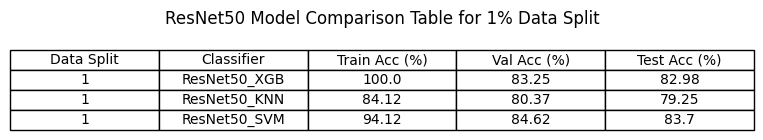

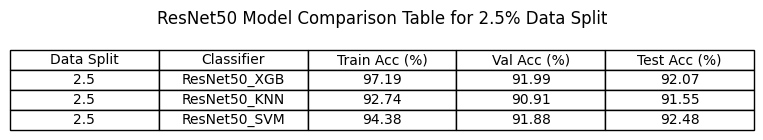

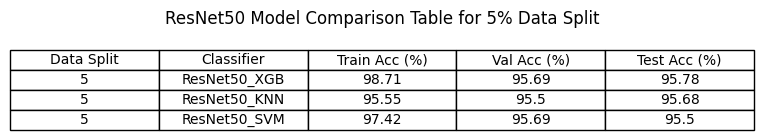

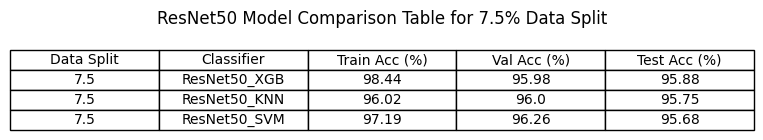

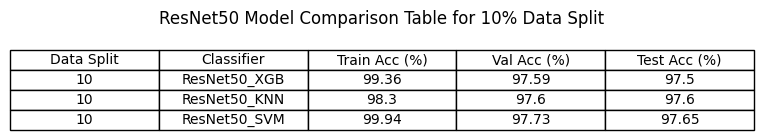

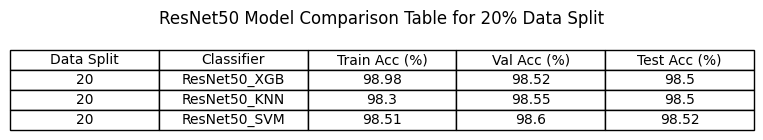

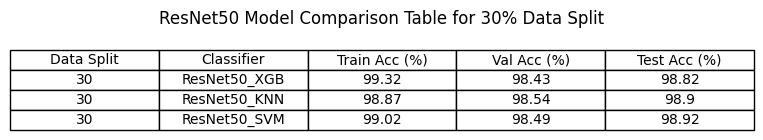

In [24]:
# Visualization of results
import matplotlib.pyplot as plt
import pandas as pd
for i, p in enumerate(dataper):
    data = {
        'Data Split': [p for i in range(3)],
        'Classifier': ['ResNet50_XGB', 'ResNet50_KNN', 'ResNet50_SVM'],
        'Train Acc (%)': [round(xgb[i][0]*100, 2),
                          round(knn[i][0]*100,2),
                          round(svc_acc[i][0]*100,2)],
        
        'Val Acc (%)': [round(xgb[i][1]*100,2),
                        round(knn[i][1]*100,2),
                        round(svc_acc[i][1]*100,2)],
        
        'Test Acc (%)': [round(xgb[i][2]*100,2),
                         round(knn[i][2]*100,2),
                         round(svc_acc[i][2]*100,2)]
    }
    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize=(8, 1))
    ax.axis('tight')
    ax.axis('off')
    tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    plt.title(f'ResNet50 Model Comparison Table for {p}% Data Split', pad=20)
    plt.show()

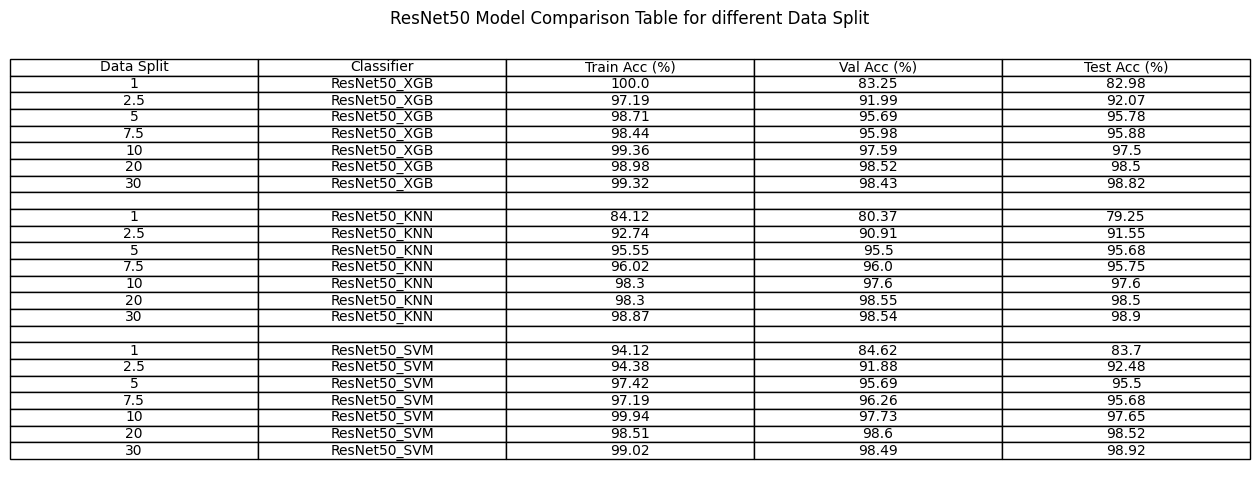

In [25]:
# Visualization of results
import matplotlib.pyplot as plt
import pandas as pd
data = {
    'Data Split': [i for i in dataper]+[" "]+[i for i in dataper]+[" "]+[i for i in dataper],
    'Classifier': ['ResNet50_XGB' for i in dataper] +[" "]+ ['ResNet50_KNN' for i in dataper] +[" "]+  ['ResNet50_SVM' for i in dataper],
    'Train Acc (%)': [round(xgb[i][0]*100, 2) for i in range(len(dataper))] +[" "]+ [round(knn[i][0]*100,2) for i in range(len(dataper))] +[" "]+ [round(svc_acc[i][0]*100,2) for i in range(len(dataper))],        
    'Val Acc (%)': [round(xgb[i][1]*100, 2) for i in range(len(dataper))] +[" "]+ [round(knn[i][1]*100,2) for i in range(len(dataper))] +[" "]+ [round(svc_acc[i][1]*100,2) for i in range(len(dataper))],
    'Test Acc (%)': [round(xgb[i][2]*100, 2) for i in range(len(dataper))] +[" "]+ [round(knn[i][2]*100,2) for i in range(len(dataper))] +[" "]+ [round(svc_acc[i][2]*100,2) for i in range(len(dataper))],
}
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(16, 6))
# ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
# tbl.auto_set_font_size(False)
# tbl.set_fontsize(10)
# tbl.scale(1.2, 1.2)
plt.title(f'ResNet50 Model Comparison Table for different Data Split', pad=0)
plt.show()